Single spillover (non-recurrent) with finite population and SIS dynamics, disease-induced death, and vital dynamics.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#class representing one simulation.

class Sim:
    def __init__(self, times, betas, gammas, deltas, I, S, D):
        
        self.outcome = None
        
        #these are all arrays of the same length
        self.times = times #all the times of new events (infections, recoveries, & deaths)
        self.betas = betas #the corresponding betas. if the event was not an infection, the corresponding beta is "None"
        self.gammas = gammas #the corresponding gammas. if the event was not an infection, the corresponding gamma is "None"
        self.deltas = deltas #the corresponding deltas. if the event was a not an infection, the corresponding delta is "None"
        self.I = I #the number of infecteds, inclusive of the new event
        self.S = S #the number of susceptibles, inclusive of the new event
        self.D = D #the number of dead, inclusive of the new event
        
    def append(self, t, beta, gamma, delta, I, S, D):
        self.times.append(t)
        self.betas.append(beta)
        self.gammas.append(gamma)
        self.deltas.append(delta)
        self.I.append(I)
        self.S.append(S)
        self.D.append(D)
    
    def set_outcome(self, outcome):
        self.outcome = outcome

In [34]:
def sim_finite_vitals(S_0, beta_0, gamma_0, delta_0, mu_1=0, mu_2=0, mu_3=0, t_thresh = 1000, I_0=1, D_0=0, b = 0.03, d = 0.00003):

    #initialize time variable
    t=0
    
    #initialize return object
    sim = Sim([t], [beta_0], [gamma_0], [delta_0], [I_0], [S_0], [D_0])
    
    #initialize counters
    S = S_0; I = I_0; D = D_0
    
    #initialize matrix of active cases. each case is a row of length 4.
    infecteds=np.array([[beta_0, gamma_0, delta_0, t]]*I_0)
    
    #initialize running sums over all currently infected people    
    beta_sum = beta_0*I_0; gamma_sum = gamma_0*I_0; delta_sum = delta_0*I_0
    
    while True:
        
        total_pop = S + I #total living population
        
        #grab arrays of all betas, gammas, deltas of currently infected people
        betas = infecteds[:,0]; gammas = infecteds[:,1]; deltas = infecteds[:,2]
        
        #adjust betas to actual transmission rates, which depend on proportion of population that is susceptible
        trans_rates = betas*S/total_pop
        trans_rates_sum = beta_sum*S/total_pop #sum all transmission rates
        
        
        #compute interevent time (for the whole population)
        
        #compute overall rate of events
        #(sum of transmission, recovery, disease-death rates of infecteds, plus immigration/birth and natural death rates)
        overall_rate = trans_rates_sum + gamma_sum + delta_sum + b + d*total_pop
        
        #draw from exponential distribution with this rate
        dt = np.random.exponential(scale=1/overall_rate) #interevent time
        t += dt #actual time of new event
        
        #return if next event is later than t_thresh
        if t > t_thresh: return sim
        
        
        #otherwise check if the event was a new immigration or natural death
        ev = np.random.rand() #draw from uniform distribution over [0, 1)
        prob_nat_b = b/overall_rate #probability it was a natural birth
        prob_nat_d = d*total_pop/overall_rate #probability it was a natural death
        
        if (ev < prob_nat_b): #new immigration
            
            #update counter
            S += 1
            
            #update return object
            sim.append(t, None, None, None, I, S, D)
                    
        elif (ev < prob_nat_b + prob_nat_d): #natural death
            
            #who died? susceptible or infected?
            i = np.random.randint(total_pop) #draw a random living person
            
            if (i < I): #it was infected person number i
                
                #grab their specific beta, gamma, delta
                beta = betas[i]; gamma = gammas[i]; delta = deltas[i]
                
                #update running sums
                beta_sum -= beta; gamma_sum -= gamma; delta_sum -= delta
                
                #delete them from the infecteds array
                infecteds = np.delete(infecteds, i, axis=0)

                #update counters
                I -= 1; D += 1

                #update return object
                sim.append(t, None, None, None, I, S, D)

                #check for extinction and return if so
                if I == 0: 
                    sim.set_outcome(0)
                    return sim
                
            else: #it was a susceptible person
                
                #update counters
                S -= 1; D += 1

                #update return object
                sim.append(t, None, None, None, I, S, D)
        
        
        else: #otherwise, it was a transmission, recovery, or disease-induced death
        
            #figure out which infected person the event happened to
            i = np.random.choice(I, p=(trans_rates+gammas+deltas)/(overall_rate-b-d*total_pop)) #draw index of that person

            #grab their specific beta, gamma, delta, transmission rate
            beta = betas[i]; gamma = gammas[i]; delta = deltas[i]; trans_rate = beta*S/total_pop

            #figure out what they did: transmit, recover, or die
            ev = np.random.rand() #draw from uniform distribution over [0, 1)
            prob_trans = trans_rate / (trans_rate + gamma + delta) #probability of transmission
            prob_rec = gamma / (trans_rate + gamma + delta) #probability of recovery

            if (ev < prob_trans): #transmission

                #pick beta, gamma, delta for new case
                #mutation is a number drawn from normal distribution with std dev mu_1, mu_2, or mu_3 respectively
                #don't allow negative result
                mut1 = np.random.normal(loc=0.0, scale=mu_1); mut2 = np.random.normal(loc=0.0, scale=mu_2); mut3 = np.random.normal(loc=0.0, scale=mu_3)
                new_beta = max(0, beta + mut1); new_gamma = max(0, gamma + mut2); new_delta = max(0, delta + mut3)

                #append new case to array of currently infected people
                infecteds = np.append(infecteds, [[new_beta, new_gamma, new_delta, t]], axis=0)

                #update counters
                I += 1; S -= 1

                #update running sums
                beta_sum += new_beta; gamma_sum += new_gamma; delta_sum += new_delta

                #update return object
                sim.append(t, new_beta, new_gamma, new_delta, I, S, D)

            elif (ev < prob_trans + prob_rec): #recovery
                
                #delete them from the infecteds array
                infecteds = np.delete(infecteds, i, axis=0)

                #update counters
                I -= 1; S += 1

                #update running sums
                beta_sum -= beta; gamma_sum -= gamma; delta_sum -= delta

                #update return object
                sim.append(t, None, None, None, I, S, D)

                #check for extinction and return if so
                if I == 0: 
                    sim.set_outcome(0)
                    return sim
                
            else: #disease-induced death

                #delete them from the infecteds array
                infecteds = np.delete(infecteds, i, axis=0)

                #update counters
                I -= 1; D += 1

                #update running sums
                beta_sum -= beta; gamma_sum -= gamma; delta_sum -= delta

                #update return object
                sim.append(t, None, None, None, I, S, D)

                #check for extinction and return if so
                if I == 0: 
                    sim.set_outcome(0)
                    return sim

None


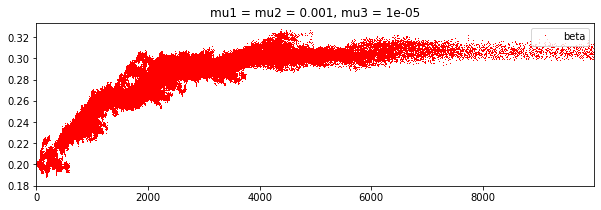

In [ ]:
%%time 

#parameters
S_0 = 1000
I_0 = 1

beta_0 = 0.2
gamma_0 = 0.2
delta_0 = 0.001

mu = 0.001
mu_1 = mu; mu_2 = mu
mu_3 = 0.00001

b = 0.3
d = 0.0003

t_thresh = 10000


s = None

while True:
    s = sim_finite_vitals(S_0, beta_0, gamma_0, delta_0, mu_1 = mu_1, mu_2 = mu_2, mu_3 = mu_3, t_thresh = t_thresh, I_0 = I_0, b = b, d = d)
    if s.times[-1] > 1000: break #get a simulation where the disease spreads for at least this many days
    #break
        
times = s.times; betas = s.betas; gammas = s.gammas; deltas = s.deltas; I = s.I; S = s.S; D = s.D

print(s.outcome)

#plot betas over time
plt.figure(figsize=(10,3))
plt.plot(times, betas, ",r", label='beta')
plt.title('mu1 = mu2 = {}, mu3 = {}'.format(mu_1, mu_3))
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend(loc="upper right"); plt.show()

#plot gammas over time
plt.figure(figsize=(10,3))
plt.plot(times, gammas, ",g", label='gamma')
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend(loc="upper right"); plt.show()

#plot deltas over time
plt.figure(figsize=(10,3))
plt.plot(times, deltas, ",b", label='delta')
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend(loc="upper right"); plt.show()

#plot I, S over time
plt.figure(figsize=(10,3))
plt.plot(times, I, 'blue', label='infected')
plt.plot(times, S, 'orange', label='susceptible')
plt.xlabel("t")
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend(loc="center right"); plt.show()

#plot D and total living pop over time
plt.figure(figsize=(10,3))
plt.plot(times, D, 'red', label='dead')
plt.plot(times, np.array(I)+np.array(S), 'purple', label='alive')
plt.plot(times, np.array(I)+np.array(S)+np.array(D), 'blue', label='total')
plt.xlabel("t")
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend(loc="center right"); plt.show()

In [78]:
#for saving sample simulations
import pickle

In [272]:
#describe simulation
#pickled to:

file = open('file.txt', 'wb')
pickle.dump(s, file)
file.close()

In [ ]:
#open a pickled simulation

file = open('file.txt', 'rb')
s = pickle.load(file)
file.close()